# Sprint25　GAN

# ライブラリのimport

In [56]:
from keras.datasets import mnist
from keras.layers import BatchNormalization, Dense, Flatten, Input, Reshape,Embedding, multiply,subtract
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model,Sequential
from keras.optimizers import Adam
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.utils import to_categorical

In [50]:
class VanillaGAN():
    """
    VanillaGAN
    Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., and Bengio, Y. (2014). Generative adversarial nets. In NIPS’2014. https://arxiv.org/pdf/1406.2661.pdf
    Parameters
    ----------------
    img_shape : tuple of int
        生成する画像の形。順番は（縦, 幅, チャンネル数）。(default : (28, 28, 1))
    noise_dim : int
        潜在変数の次元数 (default : 100)
    """
    def __init__(self, img_shape=(28, 28, 1), noise_dim=100):
        # 諸々定義
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        # モデルの作成とコンパイル
        self.compile_models()
        
    def compile_models(self):
        """
        Modelインスタンスのコンパイルを行う
        """
        # ディスクリミネータの定義とコンパイル
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])
        # 結合モデルの定義とコンパイル
        self.adversarial = self.adversarial_model()
        self.adversarial.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        print('-----------------discriminator')
        print(self.discriminator.summary())
        print('-----------------generator')
        print(self.generator.summary())
        print('-----------------adversarial')
        print(self.adversarial.summary())
        
    def generator_model(self):
        """
        GeneratorのModelインスタンスを作る
        """
        noise = Input(shape=(self.noise_dim,))
        x = Dense(128, input_dim=self.noise_dim)(noise)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(np.prod(self.img_shape), activation='tanh')(x)
        gen_img = Reshape(self.img_shape)(x)
        return Model(inputs=noise, outputs=gen_img)
    
    def discriminator_model(self):
        """
        DiscriminatorのModelインスタンスを作る
        """
        img = Input(shape=self.img_shape)
        x = Flatten(input_shape=self.img_shape)(img)
        # 問題2で作成
        x = Dense(1024, input_dim=784)(x)
        x = LeakyReLU(0.2)(x)
        x = Dense(512)(x)
        x = LeakyReLU(0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(0.2)(x)
        validity = Dense(1, activation='sigmoid')(x)
        return Model(inputs=img, outputs=validity)
    
    def adversarial_model(self):
        """
        DiscriminatorとGeneratorを繋げたModelインスタンスを作る
        """
        self.generator = self.generator_model()
        self.discriminator.trainable = False
        noise = Input(shape=(self.noise_dim,))
        # 問題3で作成
        x = self.generator(noise)
        validity = self.discriminator(x)
        return Model(inputs=noise, outputs=validity)
    
    def create_noise(self, batch_size):
        """
        Parameters
        ----------------
        batch_size : int
            ミニバッチのサイズ
        Returns
        ----------------
        noise : ndarray, shape(batch_size, noise_dim)
            ノイズ（ミニバッチのサイズ×ノイズの次元数）
        """
        # 問題1で作成
        noise = np.random.normal(0, 1, size=[batch_size,100])
        return noise
    
    def train(self, n_steps, batch_size=128, sample_interval=100):
        """
        VanillaGANを学習する
        Parameters
        ----------------
        n_steps : int
            学習するステップ数   
        batch_size : int
            バッチサイズ (default : 128)
        sample_interval : int
            サンプル画像を生成して表示・保存するステップの間隔 (default : 100)
        """
        # フォルダ作成
        os.makedirs("gen_imgs_vanilla", exist_ok=True)
        # 説明変数と目的変数の取得と整形
        (X_train, y_train), (_, _) = mnist.load_data()
        X_train = X_train/127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        # ラベル生成
        real_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))
        # 学習
        for step in range(n_steps):
            # バッチデータ取得
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]
            noise = self.create_noise(batch_size)
            # train the discriminator
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(real_imgs, real_label)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake_label)
            d_loss = (d_loss_real[0] + d_loss_fake[0])/2
            # train the generator
            self.adversarial.layers[2]
            g_loss = self.adversarial.train_on_batch(noise, real_label)
            if step % sample_interval == 0:
                self.show_sample_images(step,)
                print ("%d step, [D loss: %f] [G loss: %f]" % (step, d_loss, g_loss))
    def show_sample_images(self, step):
        """
        サンプル画像を生成して表示・保存する
        Parameters:
        ----------------
        step : int
            ステップの番号
        """
        n_sample_rows, n_sample_cols = (4, 4)
        noise = self.create_noise(n_sample_rows*n_sample_cols)
        gen_imgs = self.generator.predict(noise)
        gen_imgs = gen_imgs/2 + 0.5
        fig, axs = plt.subplots(n_sample_rows, n_sample_cols)
        count = 0
        for row in range(n_sample_rows):
            for col in range(n_sample_cols):
                axs[row, col].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[row, col].axis('off')
                count += 1
        display.clear_output(wait=True)
        display.display(plt.gcf())
        fig.savefig("gen_imgs_vanilla/%d.png" % (step))
        plt.close()

In [51]:
vanilla_gan = VanillaGAN()

-----------------discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)     

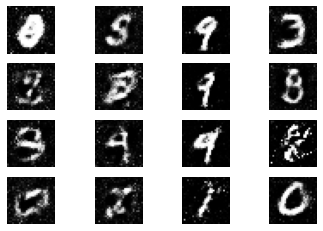

1900 step, [D loss: 0.611320] [G loss: 1.526825]


In [52]:
vanilla_gan.train(n_steps=2000, batch_size=128)

# 問題5　ConditionalGANの新規性の読解

+ 制御可能なパラメータを持たせた条件付きのGAN
+ 制御可能なパラメータとは、どの数字を表すか
+ つまり、ノイズとラベルを与えると生成してほしいラベルの画像を生成してくれる

# 問題6　ConditionalGANの実装

In [69]:
class ConditionalGAN():
    def __init__(self, img_shape=(28, 28, 1), noise_dim=100):
        # 諸々定義
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5)
        # モデルの作成とコンパイル
        self.compile_models()

    def compile_models(self):
        """
        Modelインスタンスのコンパイルを行う
        """
        # ディスクリミネータモデル作成とコンパイル
        self.discriminator = self.discriminator_model()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=self.optimizer,
            metrics=['accuracy'])
        # 結合モデルの定義とコンパイル
        self.adversarial = self.adversarial_model()
        self.adversarial.compile(loss=['binary_crossentropy'],
            optimizer=self.optimizer)
        print('-----------------discriminator')
        print(self.discriminator.summary())
        print('-----------------generator')
        print(self.generator.summary())
        print('-----------------adversarial')
        print(self.adversarial.summary())
        
    def adversarial_model(self):
        """
        DiscriminatorとGeneratorを繋げたModelインスタンスを作る
        """

        # ジェネレータモデル作成
        self.generator = self.generator_model()

        # ジェネレータモデル作成のためのInputレイヤー定義
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(1,))
        
        # ジェネレータへの入力
        img = self.generator([noise, label])

        # ディスクリミネータの学習OFF
        self.discriminator.trainable = False

        # ディスクリミネータの出力層
        valid = self.discriminator([img, label])

        # 結合モデルの定義とコンパイル
        return Model([noise, label], valid)
        
        
    def generator_model(self):
        """
        GeneratorのModelインスタンスを作る
        """
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(10, self.noise_dim)(label))

        model_input = multiply([noise, label_embedding])
        
        x = Dense(128, input_dim=self.noise_dim)(model_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(np.prod(self.img_shape), activation='tanh')(x)
        gen_img = Reshape(self.img_shape)(x)

        return Model([noise, label], gen_img)

    def discriminator_model(self):
        """
        DiscriminatorのModelインスタンスを作る
        """
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(10, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])
        
        x = Dense(1024, input_dim=np.prod(self.img_shape))(model_input)
        x = LeakyReLU(0.2)(x)
        x = Dense(512)(x)
        x = LeakyReLU(0.2)(x)
        x = Dense(256)(x)
        x = LeakyReLU(0.2)(x)
        validity = Dense(1, activation='sigmoid')(x)

        return Model([img, label], validity)
    
    def create_noise(self, batch_size):
        """
        Parameters
        ----------------
        batch_size : int
            ミニバッチのサイズ
        Returns
        ----------------
        noise : ndarray, shape(batch_size, noise_dim)
            ノイズ（ミニバッチのサイズ×ノイズの次元数）
        """
        noise = np.random.normal(0, 1, size=[batch_size,100])
        return noise

    def train(self, n_steps, batch_size=128, sample_interval=100):
        """
        ConditionalGANを学習する
        Parameters
        ----------------
        n_steps : int
            学習するステップ数   
        batch_size : int
            バッチサイズ (default : 128)
        sample_interval : int
            サンプル画像を生成して表示・保存するステップの間隔 (default : 100)
        """
        os.makedirs("gen_imgs_conditional", exist_ok=True)
        (X_train, y_train), (_, _) = mnist.load_data()
        X_train = X_train/127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        real_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))

        for step in range(n_steps):
            # 各種学習に用いる変数の定義
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]
            labels = y_train[idx]
            noise = self.create_noise(batch_size)
            
            # ジェネレータで画像生成
            gen_imgs = self.generator.predict([noise, labels])

            # ディスクリミネータ訓練
            d_loss_real = self.discriminator.train_on_batch([real_imgs, labels], real_label)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels],fake_label)
            d_loss = (d_loss_real[0] + d_loss_fake[0])/2
            
            # 推定
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
            g_loss = self.adversarial.train_on_batch([noise, sampled_labels], real_label)
            
            # 出力
            if step % sample_interval == 0:
                self.show_sample_images(step)
                print("%d step, [D loss: %f] [G loss: %f]" %
                      (step, d_loss, g_loss))
                

    def show_sample_images(self, step):
        """進捗画像出力
        Parameters
        --------------
        step:何回目の学習か
        """
        # ノイズとラベル生成
        noise = np.random.normal(0, 1, (10, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)
        # 画像生成
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(2, 5)
        # 描画
        cnt = 0
        for i in range(2):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("number: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        # 描画
        display.clear_output(wait=True)
        display.display(plt.gcf())
        # 保存
        fig.savefig("gen_imgs_conditional/%d.png" % step)
        plt.close()

In [70]:
cgan = ConditionalGAN()

-----------------discriminator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 784)       7840        input_41[0][0]                   
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 784)          0           input_40[0][0]                   
______________________________________________________________________________

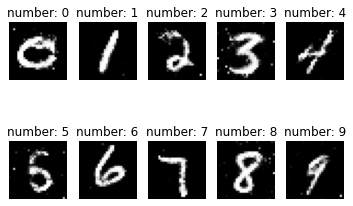

19980 step, [D loss: 0.601638] [G loss: 1.137262]


In [72]:
cgan.train(n_steps=2000, batch_size=128, sample_interval=20)